# Pump it Up: Data Mining the Water Table

### Can you predict which water pumps are faulty?
Using data from Taarifa and the Tanzanian Ministry of Water, can you predict which pumps are functional, which need some repairs, and which don't work at all? This is an intermediate-level practice competition. Predict one of these three classes based on a number of variables about what kind of pump is operating, when it was installed, and how it is managed. A smart understanding of which waterpoints will fail can improve maintenance operations and ensure that clean, potable water is available to communities across Tanzania.

Competition:
https://www.drivendata.org/competitions/7/

TODO:
- make sure new categories of the test set (not present in the train set) belong to 'Others'
- new column: well age
- new column: funder == installer? (check if this has an effect on status_group)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import os
import sys

import numpy as np
import pandas as pd
import seaborn as sns

import sklearn as sk
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate, cross_val_predict, cross_val_score, train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

import xgboost as xgb

In [2]:
# Download the data and load with pandas
TRAIN_DATA_URL = 'https://s3.amazonaws.com/drivendata/data/7/public/4910797b-ee55-40a7-8668-10efd5c1b960.csv'
TRAIN_LABELS_URL = 'https://s3.amazonaws.com/drivendata/data/7/public/0bf8bc6e-30d0-4c50-956a-603fc693d966.csv'
TEST_DATA_URL = 'https://s3.amazonaws.com/drivendata/data/7/public/702ddfc5-68cd-4d1d-a0de-f5f566f76d91.csv'

train_values = pd.read_csv(TRAIN_DATA_URL,
                    index_col='id')
train_targets = pd.read_csv(TRAIN_LABELS_URL,
                     index_col='id')
test = pd.read_csv(TEST_DATA_URL,
                   index_col='id')

In [3]:
# merge training values and labels
train = pd.merge(train_values, train_targets, left_index=True, right_index=True)

def status_group_mapper(status_group: str):
    if status_group == 'functional':
        return 2
    elif status_group == 'non functional':
        return 0
    else:
        return 1

# map status_group label to numeric class (0: non-func, 1: repair, 2: func)
train['status_group'] = train['status_group'].apply(status_group_mapper)
train.head()

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
id,,,,,,,,,,,,,,,,,,,,,
69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,2
8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,2
34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,2
67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,0
19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,2


In [4]:
# all train object-columns to lower-case
for cname in train.columns:
    if train[cname].dtype == object:
        train[cname] = train[cname].str.lower()

In [5]:
# all test object-columns to lower-case
for cname in test.columns:
    if test[cname].dtype == object:
        test[cname] = test[cname].str.lower()

### Explore the dataset

- amount_tsh - Total static head (amount water available to waterpoint)
- date_recorded - The date the row was entered
- funder - Who funded the well
- gps_height - Altitude of the well
- installer - Organization that installed the well
- longitude - GPS coordinate
- latitude - GPS coordinate
- wpt_name - Name of the waterpoint if there is one
- num_private -
- basin - Geographic water basin
- subvillage - Geographic location
- region - Geographic location
- region_code - Geographic location (coded)
- district_code - Geographic location (coded)
- lga - Geographic location
- ward - Geographic location
- population - Population around the well
- public_meeting - True/False
- recorded_by - Group entering this row of data
- scheme_management - Who operates the waterpoint
- scheme_name - Who operates the waterpoint
- permit - If the waterpoint is permitted
- construction_year - Year the waterpoint was constructed
- extraction_type - The kind of extraction the waterpoint uses
- extraction_type_group - The kind of extraction the waterpoint uses
- extraction_type_class - The kind of extraction the waterpoint uses
- management - How the waterpoint is managed
- management_group - How the waterpoint is managed
- payment - What the water costs
- payment_type - What the water costs
- water_quality - The quality of the water
- quality_group - The quality of the water
- quantity - The quantity of water
- quantity_group - The quantity of water
- source - The source of the water
- source_type - The source of the water
- source_class - The source of the water
- waterpoint_type - The kind of waterpoint
- waterpoint_type_group - The kind of waterpoint

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 69572 to 26348
Data columns (total 40 columns):
amount_tsh               59400 non-null float64
date_recorded            59400 non-null object
funder                   55765 non-null object
gps_height               59400 non-null int64
installer                55745 non-null object
longitude                59400 non-null float64
latitude                 59400 non-null float64
wpt_name                 59400 non-null object
num_private              59400 non-null int64
basin                    59400 non-null object
subvillage               59029 non-null object
region                   59400 non-null object
region_code              59400 non-null int64
district_code            59400 non-null int64
lga                      59400 non-null object
ward                     59400 non-null object
population               59400 non-null int64
public_meeting           0 non-null float64
recorded_by              59400 non-null object

In [7]:
train.describe()

,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,public_meeting,permit,construction_year,status_group
count,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,0.0,0.0,59400.000000,59400.000000
mean,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,NaN,NaN,1300.652475,1.158838
std,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,NaN,NaN,951.620547,0.949794
min,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,NaN,NaN,0.000000,0.000000
25%,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,NaN,NaN,0.000000,0.000000
50%,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,NaN,NaN,1986.000000,2.000000
75%,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,NaN,NaN,2004.000000,2.000000
max,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,NaN,NaN,2013.000000,2.000000


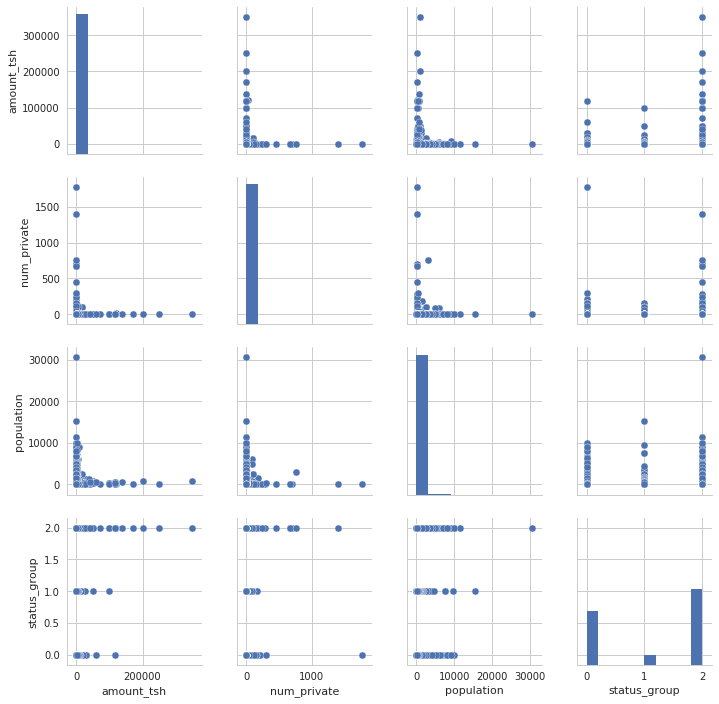

In [8]:
def matrix_plot(cols):
    sns.set(style='whitegrid',context='notebook')
    sns.pairplot(train[cols],size=2.5)
    plt.show()
    
matrix_plot(['amount_tsh','num_private','population','status_group'])

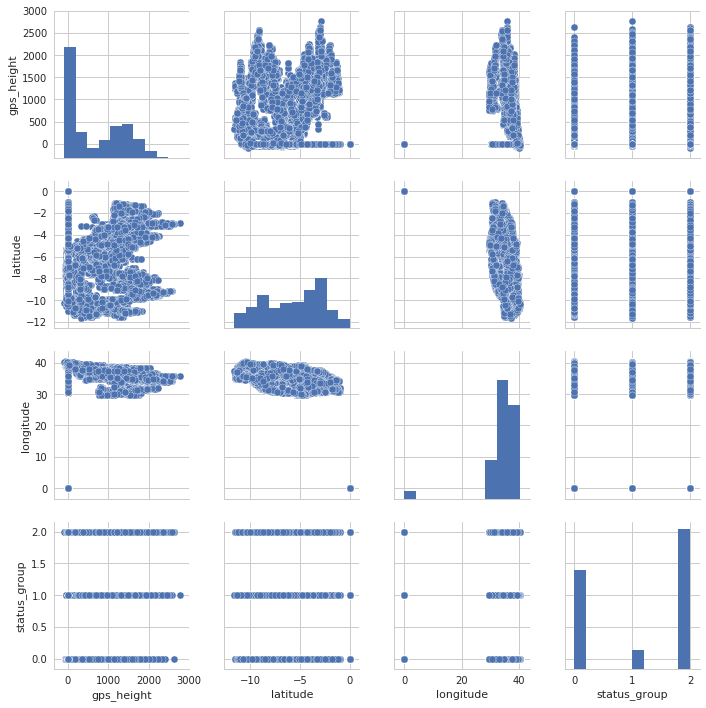

In [9]:
matrix_plot(['gps_height','latitude', 'longitude','status_group'])

In [10]:
# check for missing values
train.isna().sum()

amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting           59400
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                   59400
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_group                0
quantity

In [11]:
def check_redundant(col1, col2):
    result = np.where(train[col1] != train[col2])[0]
    print('{} != {}: {}/{}'.format(col1, col2, result.size, len(train)))

# check redundancies
check_redundant('quantity', 'quantity_group')
check_redundant('waterpoint_type', 'waterpoint_type_group')
check_redundant('water_quality', 'quality_group')
check_redundant('management', 'management_group')
check_redundant('payment', 'payment_type') # different naming, but is identical
check_redundant('source', 'source_type')
check_redundant('source', 'source_class')
check_redundant('extraction_type', 'extraction_type_group')
check_redundant('extraction_type', 'extraction_type_class')
check_redundant('funder', 'installer')

quantity != quantity_group: 0/59400
waterpoint_type != waterpoint_type_group: 6103/59400
water_quality != quality_group: 51664/59400
management != management_group: 56227/59400
payment != payment_type: 24841/59400
source != source_type: 22392/59400
source != source_class: 59334/59400
extraction_type != extraction_type_group: 2469/59400
extraction_type != extraction_type_class: 21426/59400
funder != installer: 40470/59400


### Data preparation

#### quantity, quantity_group

In [12]:
# TODO remove or merge redundant columns
train = train.drop(columns=['quantity_group'])
test = test.drop(columns=['quantity_group'])

#### population

In [13]:
train['population'].value_counts()
# replace 0 (zero) in columns with NAs
#train = train.replace({'population':0}, np.nan)
# TODO: binning? p<100, 100<p<500, 500<p<1000, 1000<p

0       21381
1        7025
200      1940
150      1892
250      1681
300      1476
100      1146
50       1139
500      1009
350       986
120       916
400       775
60        706
30        626
40        552
80        533
450       499
20        462
600       438
230       388
75        289
1000      278
800       269
90        265
130       264
25        255
320       249
35        245
360       222
140       215
        ...  
8848        1
628         1
4520        1
468         1
693         1
725         1
789         1
821         1
5300        1
3127        1
2345        1
3031        1
886         1
392         1
424         1
2807        1
726         1
694         1
2569        1
4788        1
662         1
4660        1
406         1
1032        1
1160        1
3241        1
1960        1
1685        1
2248        1
1439        1
Name: population, Length: 1049, dtype: int64

#### funder, installer

In [14]:
# replace 0 (zero) in columns with NAs
train = train.drop(columns=['funder'])
train = train.replace({'installer':'0'}, 'other')
train = train.replace({'installer': np.nan}, 'other') # other or unknown?

test = test.drop(columns=['funder'])
test = test.replace({'installer':'0'}, 'other')
test = test.replace({'installer': np.nan}, 'other') # other or unknown?

In [15]:
def replace_mapper(value: str, contains: str, label: str):
    if contains in value:
        return label
    return value

train['installer'] = train['installer'].apply(lambda v : replace_mapper(v, 'gov', 'government'))
train['installer'] = train['installer'].apply(lambda v : replace_mapper(v, 'comm', 'community'))
train['installer'] = train['installer'].apply(lambda v : replace_mapper(v, 'danid', 'danida'))

test['installer'] = test['installer'].apply(lambda v : replace_mapper(v, 'gov', 'government'))
test['installer'] = test['installer'].apply(lambda v : replace_mapper(v, 'comm', 'community'))
test['installer'] = test['installer'].apply(lambda v : replace_mapper(v, 'danid', 'danida'))

In [16]:
installer = train['installer'].value_counts()
installer_few = train['installer'].isin(installer.index[installer < 100])
train.loc[installer_few, 'installer'] = 'other'
train['installer'].value_counts()

dwe                              17405
other                            15880
government                        3753
community                         1974
danida                            1676
hesawa                            1395
rwe                               1206
district council                   961
kkkt                               910
tcrs                               707
world vision                       699
ces                                610
amref                              443
lga                                413
tasaf                              411
wedeco                             398
fini water                         389
dmdd                               376
norad                              360
twesa                              316
da                                 308
wu                                 301
acra                               278
sema                               249
dw                                 246
jaica                    

In [17]:
installer_values = train['installer'].unique()

test['installer'] = test['installer'].apply(lambda v: 'other' if v not in installer_values else v)

#### waterpoint, waterpoint_type_group

In [18]:
print(train['waterpoint_type'].value_counts(dropna=False))
print(train['waterpoint_type_group'].value_counts(dropna=False))

communal standpipe             28522
hand pump                      17488
other                           6380
communal standpipe multiple     6103
improved spring                  784
cattle trough                    116
dam                                7
Name: waterpoint_type, dtype: int64
communal standpipe    34625
hand pump             17488
other                  6380
improved spring         784
cattle trough           116
dam                       7
Name: waterpoint_type_group, dtype: int64


In [19]:
# make dam (only 7 instances) to others, and drop waterpoint_type_group
train = train.replace({'waterpoint_type':'dam'}, 'other')
train = train.drop(columns=['waterpoint_type_group'])

test = test.replace({'waterpoint_type':'dam'}, 'other')
test = test.drop(columns=['waterpoint_type_group'])

#### construction_year, date_recorded, well_age

In [20]:
# trim the record date to the year
train['date_recorded'] = train['date_recorded'].apply(lambda v : float(v[:4]))
test['date_recorded'] = test['date_recorded'].apply(lambda v : float(v[:4]))

# fill construction_year==0 with the min value (I expect that the year is unknown because it's a while ago)
train = train.replace({'construction_year':0}, np.nan)
test = test.replace({'construction_year':0}, np.nan)
min_construction_year = int(train['construction_year'].min())
train = train.replace({'construction_year':np.nan}, min_construction_year)
test = test.replace({'construction_year':np.nan}, min_construction_year)

# create a new column 'well_age'
train['well_age'] = train['date_recorded'] - train['construction_year']
test['well_age'] = test['date_recorded'] - test['construction_year']

#### extraction_type, extraction_type_group, extraction_type_class

In [21]:
print(train['extraction_type'].value_counts())
print(train['extraction_type_group'].value_counts())
print(train['extraction_type_class'].value_counts())

gravity                      26780
nira/tanira                   8154
other                         6430
submersible                   4764
swn 80                        3670
mono                          2865
india mark ii                 2400
afridev                       1770
ksb                           1415
other - rope pump              451
other - swn 81                 229
windmill                       117
india mark iii                  98
cemo                            90
other - play pump               85
walimi                          48
climax                          32
other - mkulima/shinyanga        2
Name: extraction_type, dtype: int64
gravity            26780
nira/tanira         8154
other               6430
submersible         6179
swn 80              3670
mono                2865
india mark ii       2400
afridev             1770
rope pump            451
other handpump       364
other motorpump      122
wind-powered         117
india mark iii        98
Name: ext

In [25]:
# we only keep extraction_type_class, since all are quite similar and this one has the most understandable groups
train = train.drop(columns=['extraction_type', 'extraction_type_class'])
test = test.drop(columns=['extraction_type', 'extraction_type_class'])

train = train.replace({'extraction_type_group':'india mark ii'}, 'india mark')
train = train.replace({'extraction_type_group':'india mark iii'}, 'india mark')
test = test.replace({'extraction_type_group':'india mark ii'}, 'india mark')
test = test.replace({'extraction_type_group':'india mark iii'}, 'india mark')

train['extraction_type_group'].value_counts()

gravity            26780
nira/tanira         8154
other               6430
submersible         6179
swn 80              3670
mono                2865
india mark          2498
afridev             1770
rope pump            451
other handpump       364
other motorpump      122
wind-powered         117
Name: extraction_type_group, dtype: int64

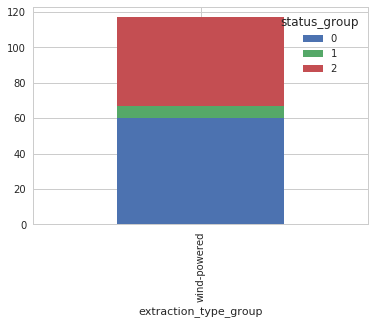

In [27]:
selected = train[train['extraction_type_group'] == 'wind-powered']
cross_table = pd.crosstab(index=selected['extraction_type_group'], columns=train['status_group'])
cross_table
cross_table.plot(kind='bar', stacked=True)
plt.show()

#### latitude, longitude, gps_height
- there are many zero (0 or -2e-8) which is not withing Tanzania (lat: (-11, -1), lng: (30, 40))
- height extremes in Tanzania are 0 to 5,895m. Minus values might be underground. Many empty 0 values.
- use basin to estimate the apprx. location

In [28]:
# ensure all unknown values are zero (0):
train = train.replace({'latitude':-2.000000e-08}, 0)
test = test.replace({'latitude':-2.000000e-08}, 0)

# bounds of min/max latitude/longitude/height for Tanzania using basin
train_bound = train[(train['latitude']!=0)&(train['longitude']!=0)&(train['gps_height']!=0)]
train_median_geo = train_bound.groupby(['basin',])['latitude','longitude','gps_height'].median()
train_median_geo

,latitude,longitude,gps_height
basin,,,
internal,-4.268302,35.367111,1504
lake nyasa,-9.796345,34.708831,1646
lake rukwa,-7.628407,31.368940,1504
lake tanganyika,-4.639630,30.329597,1286
lake victoria,-1.851610,34.063530,1286
pangani,-3.440594,37.491983,1193
rufiji,-8.456492,35.774562,1235
ruvuma / southern coast,-10.627406,38.934973,343
wami / ruvu,-6.797943,38.360608,174


In [29]:
train.loc[train['gps_height']==0, 'gps_height'] = train['basin'].apply(lambda x : train_median_geo.at[x,'gps_height'])
train.loc[train['longitude']==0, 'longitude'] = train['basin'].apply(lambda x : train_median_geo.at[x,'longitude'])
train.loc[train['latitude']==0, 'latitude'] = train['basin'].apply(lambda x : train_median_geo.at[x,'latitude'])

test.loc[test['gps_height']==0, 'gps_height'] = test['basin'].apply(lambda x : train_median_geo.at[x,'gps_height'])
test.loc[test['longitude']==0, 'longitude'] = test['basin'].apply(lambda x : train_median_geo.at[x,'longitude'])
test.loc[test['latitude']==0, 'latitude'] = test['basin'].apply(lambda x : train_median_geo.at[x,'latitude'])

#### amount_tsh

In [30]:
train['amount_tsh'].value_counts()

0.00         41639
500.00        3102
50.00         2472
1000.00       1488
20.00         1463
200.00        1220
100.00         816
10.00          806
30.00          743
2000.00        704
250.00         569
300.00         557
5000.00        450
5.00           376
25.00          356
3000.00        334
1200.00        267
1500.00        197
6.00           190
600.00         176
4000.00        156
2400.00        145
2500.00        139
6000.00        125
7.00            69
8000.00         61
750.00          59
40.00           59
10000.00        57
12000.00        51
             ...  
16000.00         2
16300.00         2
800.00           2
11000.00         2
590.00           2
520.00           2
26000.00         2
13000.00         2
9.00             1
170000.00        1
200000.00        1
900.00           1
0.25             1
53.00            1
350000.00        1
306.00           1
120000.00        1
26.00            1
59.00            1
60000.00         1
5400.00          1
70000.00    

#### management

In [31]:
train[['scheme_management', 'scheme_name', 'management', 'management_group']].head(n=20)

,scheme_management,scheme_name,management,management_group
id,,,,
69572,vwc,roman,vwc,user-group
8776,other,NaN,wug,user-group
34310,vwc,nyumba ya mungu pipe scheme,vwc,user-group
67743,vwc,NaN,vwc,user-group
19728,NaN,NaN,other,other
9944,vwc,zingibali,vwc,user-group
19816,vwc,NaN,vwc,user-group
54551,NaN,NaN,wug,user-group
53934,vwc,NaN,vwc,user-group


In [32]:
# print(train['scheme_management'].value_counts()) # almost same as management, but with NaN values
# print(train['scheme_name'].value_counts()) # 2576 different values!
print(train['management'].value_counts())
print(train['management_group'].value_counts())

vwc                 40507
wug                  6515
water board          2933
wua                  2535
private operator     1971
parastatal           1768
water authority       904
other                 844
company               685
unknown               561
other - school         99
trust                  78
Name: management, dtype: int64
user-group    52490
commercial     3638
parastatal     1768
other           943
unknown         561
Name: management_group, dtype: int64


In [33]:
train = train.replace({'management':'unknown'}, 'other')
train = train.replace({'management': 'other - school'}, 'other')
train = train.replace({'management': 'trust'}, 'other')
train = train.replace({'management_group':'unknown'}, 'other')

test = test.replace({'management':'unknown'}, 'other')
test = test.replace({'management': 'other - school'}, 'other')
test = test.replace({'management': 'trust'}, 'other')
test = test.replace({'management_group':'unknown'}, 'other')

#### region / district

In [34]:
train[['region', 'region_code', 'district_code']].head(n=20)

,region,region_code,district_code
id,,,
69572,iringa,11,5
8776,mara,20,2
34310,manyara,21,4
67743,mtwara,90,63
19728,kagera,18,1
9944,tanga,4,8
19816,shinyanga,17,3
54551,shinyanga,17,3
53934,tabora,14,6


#### basin

In [35]:
print(train['basin'].value_counts())

lake victoria              10248
pangani                     8940
rufiji                      7976
internal                    7785
lake tanganyika             6432
wami / ruvu                 5987
lake nyasa                  5085
ruvuma / southern coast     4493
lake rukwa                  2454
Name: basin, dtype: int64


region, region_code and district seem to be very similar. We will use region and binarize it later.

#### source

In [36]:
print(train['source'].value_counts())
print(train['source_type'].value_counts())
print(train['source_class'].value_counts())

spring                  17021
shallow well            16824
machine dbh             11075
river                    9612
rainwater harvesting     2295
hand dtw                  874
lake                      765
dam                       656
other                     212
unknown                    66
Name: source, dtype: int64
spring                  17021
shallow well            16824
borehole                11949
river/lake              10377
rainwater harvesting     2295
dam                       656
other                     278
Name: source_type, dtype: int64
groundwater    45794
surface        13328
unknown          278
Name: source_class, dtype: int64


In [37]:
train = train.replace({'source':'unknown'}, 'other')
test = test.replace({'source':'unknown'}, 'other')

#### payment

In [38]:
print(train['payment'].value_counts())
print(train['payment_type'].value_counts())

never pay                25348
pay per bucket            8985
pay monthly               8300
unknown                   8157
pay when scheme fails     3914
pay annually              3642
other                     1054
Name: payment, dtype: int64
never pay     25348
per bucket     8985
monthly        8300
unknown        8157
on failure     3914
annually       3642
other          1054
Name: payment_type, dtype: int64


## Visualize cleaned data

Some more visualization after the data has been cleaned up

In [39]:
def crosstab_diagram(data: pd.DataFrame, index_col: str, figsize=None):
    cross_table = pd.crosstab(index=data[index_col], columns=data['status_group'])
    cross_table.plot(kind='bar', stacked=True, figsize=figsize)
    plt.show()

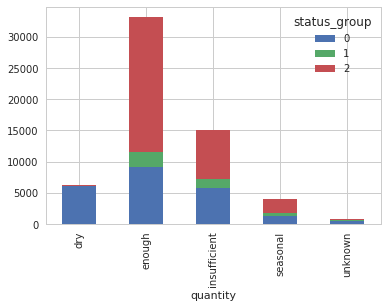

In [40]:
crosstab_diagram(train, 'quantity')

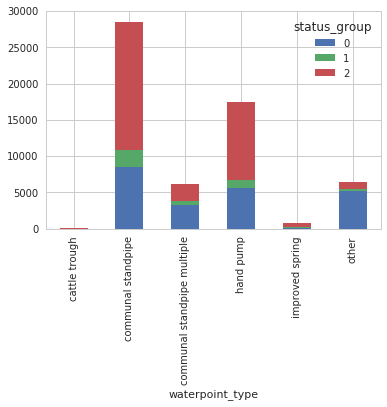

In [41]:
crosstab_diagram(train, 'waterpoint_type')

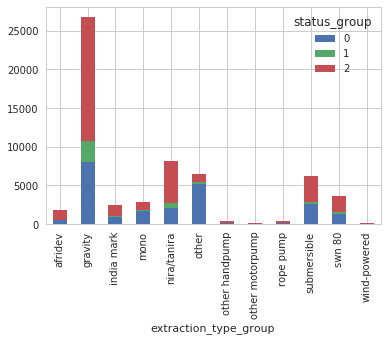

In [50]:
crosstab_diagram(train, 'extraction_type_group')

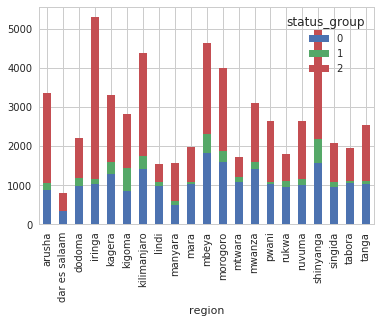

In [51]:
crosstab_diagram(train, 'region')

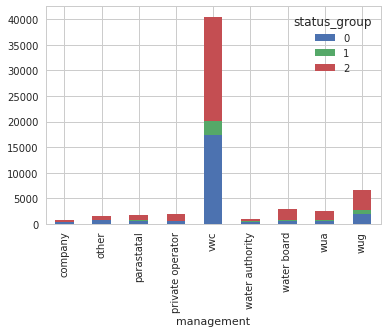

In [43]:
crosstab_diagram(train, 'management')

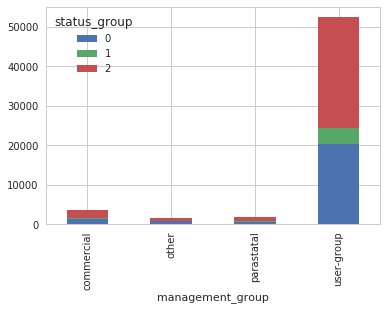

In [44]:
crosstab_diagram(train, 'management_group')

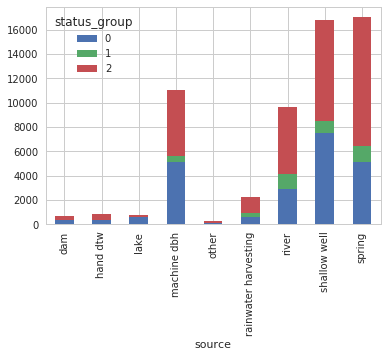

In [45]:
crosstab_diagram(train, 'source')

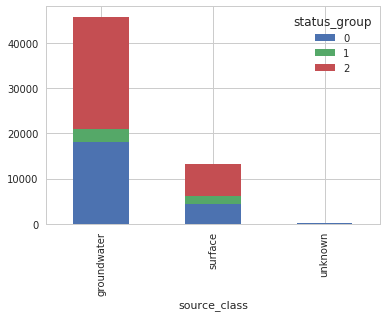

In [46]:
crosstab_diagram(train, 'source_class') # does not seam to be helpful

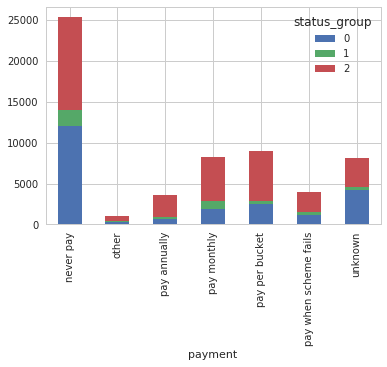

In [47]:
crosstab_diagram(train, 'payment')

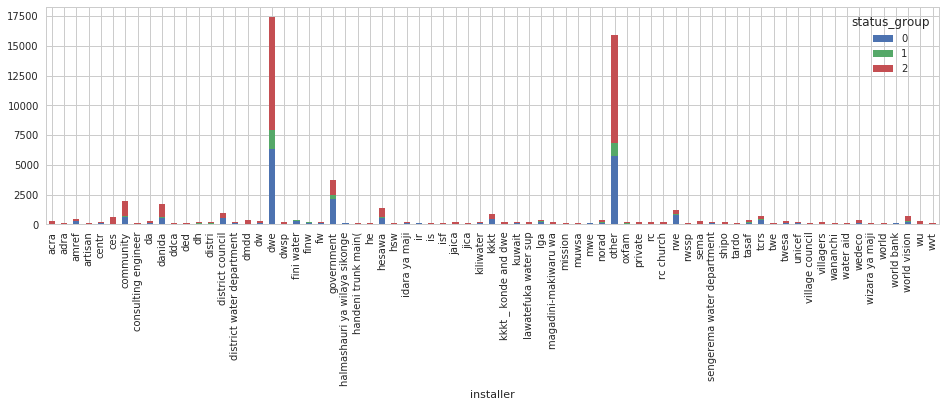

In [48]:
crosstab_diagram(train, 'installer', figsize=(16,4))

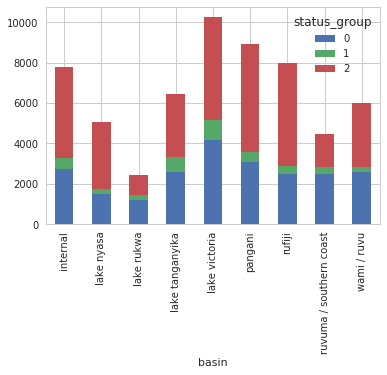

In [49]:
crosstab_diagram(train, 'basin')

## Attributes that we are interested in

In [52]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 69572 to 26348
Data columns (total 36 columns):
amount_tsh               59400 non-null float64
date_recorded            59400 non-null float64
gps_height               59400 non-null int64
installer                59400 non-null object
longitude                59400 non-null float64
latitude                 59400 non-null float64
wpt_name                 59400 non-null object
num_private              59400 non-null int64
basin                    59400 non-null object
subvillage               59029 non-null object
region                   59400 non-null object
region_code              59400 non-null int64
district_code            59400 non-null int64
lga                      59400 non-null object
ward                     59400 non-null object
population               59400 non-null int64
public_meeting           0 non-null float64
recorded_by              59400 non-null object
scheme_management        55523 non-null objec

In [54]:
numeric_cols = ['gps_height', 'latitude', 'longitude', 'well_age', 'population']
ordered_cat_cols = []
unordered_cat_cols = ['quantity', 'waterpoint_type', 'extraction_type_group', 'region',\
                      'management', 'source',\
                      'payment', 'installer', 'basin'] # source_class, management_group
all_cols = numeric_cols + ordered_cat_cols + unordered_cat_cols

## Encode categorical attributes
- LabelEncoder (ordered)
- LabelBinarizer (unordered)

In [55]:
def encode_categories(column: pd.core.series.Series):
    encoder = LabelBinarizer()
    return encoder.fit_transform(column)

In [56]:
# for column_name in unordered_cat_cols:
    # train[column_name] = encode_categories(train[column_name])

In [57]:
# encode_categories(train['quantity'])
# train['quantity']

In [58]:
training = pd.get_dummies(train[all_cols], columns=unordered_cat_cols)
training

,gps_height,latitude,longitude,well_age,population,quantity_dry,quantity_enough,quantity_insufficient,quantity_seasonal,quantity_unknown,...,installer_wvt,basin_internal,basin_lake nyasa,basin_lake rukwa,basin_lake tanganyika,basin_lake victoria,basin_pangani,basin_rufiji,basin_ruvuma / southern coast,basin_wami / ruvu
id,,,,,,,,,,,,,,,,,,,,,
69572,1390,-9.856322,34.938093,12.0,109,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
8776,1399,-2.147466,34.698766,3.0,280,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
34310,686,-3.821329,37.460664,4.0,250,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
67743,263,-11.155298,38.486161,27.0,58,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
19728,1286,-1.825359,31.130847,51.0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
9944,1193,-4.765587,39.172796,2.0,1,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
19816,1504,-3.766365,33.362410,52.0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
54551,1286,-4.226198,32.620617,52.0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
53934,1286,-5.146712,32.711100,52.0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0


In [59]:
testing = pd.get_dummies(test[all_cols], columns=unordered_cat_cols)
testing

,gps_height,latitude,longitude,well_age,population,quantity_dry,quantity_enough,quantity_insufficient,quantity_seasonal,quantity_unknown,...,installer_wvt,basin_internal,basin_lake nyasa,basin_lake rukwa,basin_lake tanganyika,basin_lake victoria,basin_pangani,basin_rufiji,basin_ruvuma / southern coast,basin_wami / ruvu
id,,,,,,,,,,,,,,,,,,,,,
50785,1996,-4.059696,35.290799,1.0,321,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
51630,1569,-3.309214,36.656709,13.0,300,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
17168,1567,-5.004344,34.767863,3.0,500,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
45559,267,-9.418672,38.058046,26.0,250,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
49871,1260,-10.950412,35.006123,13.0,60,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
52449,1685,-3.302420,36.685279,23.0,200,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
24806,550,-7.541382,36.398041,4.0,600,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
28965,234,-10.893786,39.607420,31.0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
36301,584,-10.823588,39.262951,16.0,40,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0


In [60]:
training.columns

Index(['gps_height', 'latitude', 'longitude', 'well_age', 'population',
       'quantity_dry', 'quantity_enough', 'quantity_insufficient',
       'quantity_seasonal', 'quantity_unknown',
       ...
       'installer_wvt', 'basin_internal', 'basin_lake nyasa',
       'basin_lake rukwa', 'basin_lake tanganyika', 'basin_lake victoria',
       'basin_pangani', 'basin_rufiji', 'basin_ruvuma / southern coast',
       'basin_wami / ruvu'],
      dtype='object', length=156)

In [61]:
testing.columns

Index(['gps_height', 'latitude', 'longitude', 'well_age', 'population',
       'quantity_dry', 'quantity_enough', 'quantity_insufficient',
       'quantity_seasonal', 'quantity_unknown',
       ...
       'installer_wvt', 'basin_internal', 'basin_lake nyasa',
       'basin_lake rukwa', 'basin_lake tanganyika', 'basin_lake victoria',
       'basin_pangani', 'basin_rufiji', 'basin_ruvuma / southern coast',
       'basin_wami / ruvu'],
      dtype='object', length=156)

In [62]:
train_data = training.as_matrix()
train_labels = train['status_group'].as_matrix()
test_data = testing.as_matrix()

## Model selection

#### Random Forest

In [136]:
model = RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=16, max_features='log2',
            max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0, warm_start=False,
            random_state=42)
model

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=16, max_features='log2',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

#### XGBoost

In [161]:
model = xgb.XGBClassifier(max_depth=10, n_estimators=500, learning_rate=0.1, reg_alpha=0, reg_lambda=1.0,
                          random_state=42)
model

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1.0, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

#### Simple train/test split

In [162]:
#X_train, X_test, y_train, y_test = train_test_split(train_data, train_labels, test_size=0.2, random_state=0)
X_train, y_train = (train_data, train_labels)

In [163]:
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=42,
       reg_alpha=0, reg_lambda=1.0, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


(array([4284.,    0.,    0.,    0.,    0.,  638.,    0.,    0.,    0.,
        6958.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

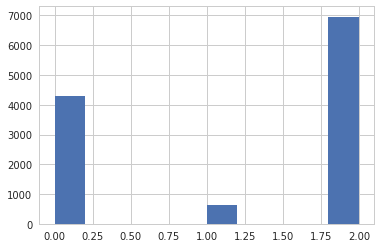

In [152]:
pred_test = model.predict(X_test)
plt.hist(pred_test)

In [153]:
accuracy_score(y_true=y_test, y_pred=pred_test)

0.9286195286195286

In [ ]:
pred_train = model.predict(X_train)
accuracy_score(y_true=y_train, y_pred=pred_train)

In [80]:
confmat = confusion_matrix(y_true=y_train, y_pred=pred_train)
confmat

array([[16516,    52,  1687],
       [  194,  2277,   979],
       [  386,   133, 25296]])

In [ ]:
print(classification_report(y_true=y_test, y_pred=prediction))

#### Cross-validation

In [159]:
model_scores = cross_val_score(model, train_data, train_labels, cv=5)

/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

In [160]:
print('Scores: {}'.format(model_scores))
print('Mean: {}'.format(model_scores.mean()))
print('Std: {}'.format(model_scores.std()))

Scores: [0.81348371 0.80582443 0.80765993 0.80252525 0.80165011]
Mean: 0.8062286867353509
Std: 0.004231456018540554


## Predictions for submission

/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


(array([5275.,    0.,    0.,    0.,    0.,  535.,    0.,    0.,    0.,
        9040.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

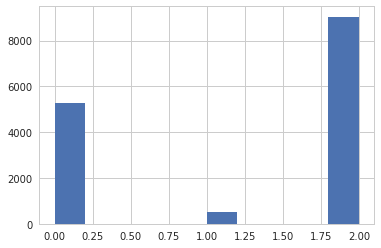

In [155]:
prediction = model.predict(test_data)
plt.hist(prediction)

In [156]:
def save_submission(predictions, test):
    data = {'id': test.index, 'status_group': predictions}

    submit = pd.DataFrame(data=data)

    vals_to_replace = {0:'non functional',
                       1:'functional needs repair',
                       2:'functional'}

    submit['status_group'] = submit['status_group'].replace(vals_to_replace)        

    submit.to_csv('pump_predictions.csv', index=False)

In [157]:
save_submission(prediction, test)